# Assignment #1: Write up a report on U.N. World Happiness Data.

Elliott Tran | 2/8/2021 | GR5074

**Explore bivariate results (Use visualizations!)**

**Describe any relationships you see between particular features and the target variable**

Below, I created a correlation matrix as well as a pairwise plot to analyze the relationship between our features of target variable, happiness. Happiness was recoded to to numerical and with ascending category order. Happiness is most correlated with GDP per capita, social support, and healthy life expectancy. It is least correlated with generosity. All features have a positive relationship with happiness overall.



In [1]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1# Colab Setup:`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
import pandas as pd
import seaborn as sns

In [3]:
happiness_df = pd.read_csv("worldhappiness2019.csv")

In [20]:
happiness_df['happiness_cat'] = happiness_df['Happiness_level'].astype("category")
happiness_df['happiness_cat'] = happiness_df['happiness_cat'].cat.reorder_categories(['Very Low', 'Low', 'Average', 'High', 'Very High'])
happiness_df['happiness_cat'] = happiness_df['happiness_cat'].cat.codes


In [21]:
happiness_df.head()

,Happiness_level,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,happiness_cat
0,Very High,Finland,1.340,1.587,0.986,0.596,0.153,0.393,Finland,Europe,Northern Europe,4
1,Very High,Denmark,1.383,1.573,0.996,0.592,0.252,0.410,Denmark,Europe,Northern Europe,4
2,Very High,Norway,1.488,1.582,1.028,0.603,0.271,0.341,Norway,Europe,Northern Europe,4
3,Very High,Iceland,1.380,1.624,1.026,0.591,0.354,0.118,Iceland,Europe,Northern Europe,4
4,Very High,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,4


In [23]:
happiness_df.corr()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,happiness_cat
GDP per capita,1.000000,0.754906,0.835462,0.379079,-0.079662,0.298920,0.789635
Social support,0.754906,1.000000,0.719009,0.447333,-0.048126,0.181899,0.738577
Healthy life expectancy,0.835462,0.719009,1.000000,0.390395,-0.029511,0.295283,0.786932
Freedom to make life choices,0.379079,0.447333,0.390395,1.000000,0.269742,0.438843,0.525097
Generosity,-0.079662,-0.048126,-0.029511,0.269742,1.000000,0.326538,0.028123
Perceptions of corruption,0.298920,0.181899,0.295283,0.438843,0.326538,1.000000,0.323730
happiness_cat,0.789635,0.738577,0.786932,0.525097,0.028123,0.323730,1.000000


In [24]:
happiness_df.dtypes

Happiness_level                  object
Country or region                object
GDP per capita                  float64
Social support                  float64
Healthy life expectancy         float64
Freedom to make life choices    float64
Generosity                      float64
Perceptions of corruption       float64
name                             object
region                           object
sub-region                       object
happiness_cat                      int8
dtype: object

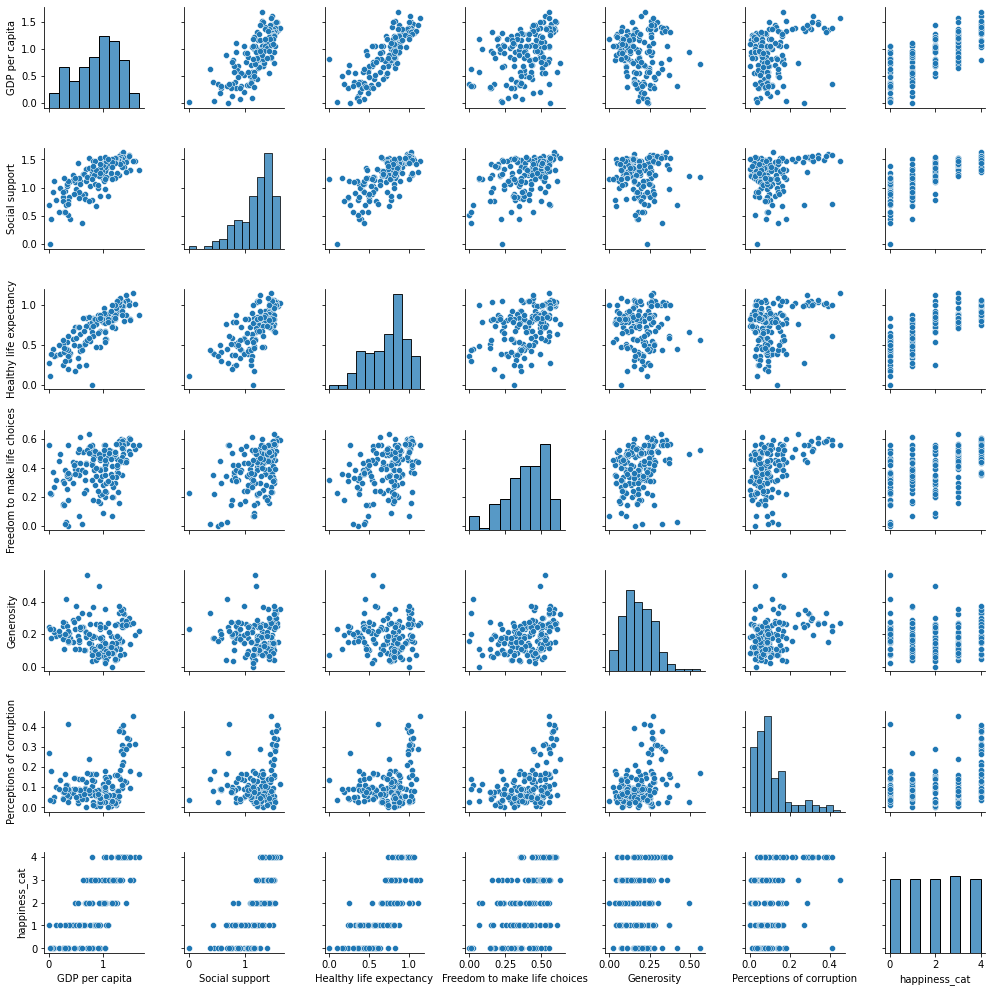

In [25]:
sns.pairplot(happiness_df, height = 2)

**Examine features that predict happiness categories using one or more models that allow for automatic feature selection. Explain any meaningful findings.**

I decided to look into automatic feature selection through SelectKBest using the ANOVA f-value test and through doing a basic decision tree classifier model to see what variables are considered most important. In both models, healthy life expectation and GDP per capita were seen as the most important to understanding happiness. The anova test ranks generosity very low while the decision tree classifier puts it at similar level to perception of corruption and social support.

In [26]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer

In [36]:
Y = happiness_df['Happiness_level'].astype("category")
X = happiness_df.drop(['Happiness_level', 'name', 'Country or region', 'region', 'happiness_cat'], axis=1)
X_nums = happiness_df.drop(['Happiness_level', 'name', 'Country or region', 'region', 'sub-region', 'happiness_cat'], axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .33)

In [73]:
numeric_features=X.columns.tolist()
numeric_features.remove('sub-region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['sub-region']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocess = preprocessor.fit(X_train) 

In [39]:
def preprocessor(data):
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [40]:
processed_data = preprocessor(X_train)

In [41]:
processed_data.shape

(104, 20)

In [78]:
X_new = SelectKBest(f_classif, k=5).fit(X_nums, Y)

In [80]:
predictors = X_nums.columns.tolist()

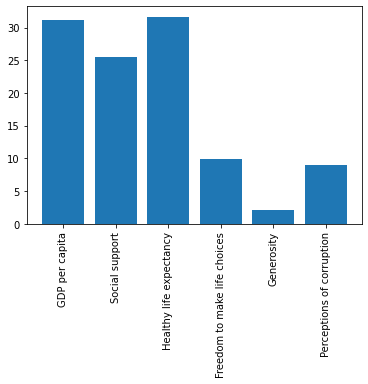

In [82]:
scores = -np.log10(X_new.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_nums, Y, test_size = .33)

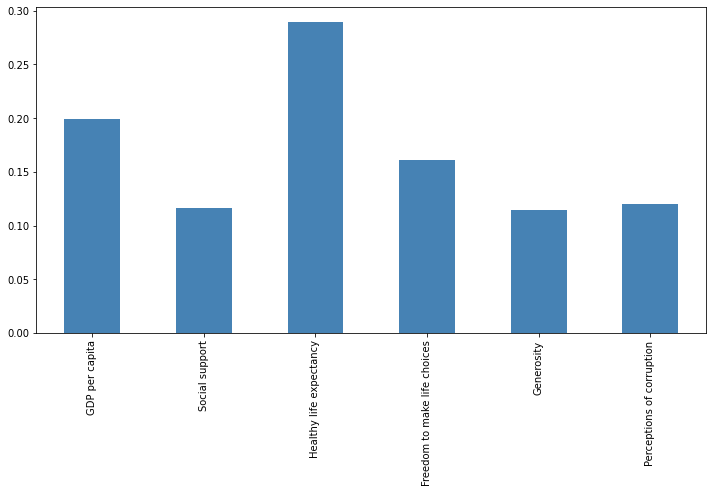

In [44]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train2, y_train2)

pd.Series(clf.feature_importances_, index=X_train2.columns).plot.bar(color='steelblue', figsize=(12, 6))

**Run at least three prediction models to try to predict World Happiness well.
Discuss which models performed better and point out relevant hyper-parameter values for successful models.
Submit your best model to the leader board for the World Happiness AI Model Share competition.
You have the option to present and/or discuss these models in your report, but it is not required.**

I tried three different models: a sequential neural network, SVC and the Random Forest Classifier. I tested out multiple hyperparameters but found the sequential neural network to be the best of the three. With the neural network, I found the 'sgd' optimizer to be the best in comparison to 'adam'  and 'Adagrad.' Furthermore, I found the model to work best when the number of nodes in the first layer is equal to the whole dataset. This let's the neural network have access to all the data at the start for analysis. It came out to be around 85% accurate.

Looking at the confusion matrix, I see that the model does best in predicting 'high' happiness and worse at 'very low' happiness. 

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD

Using TensorFlow backend.


In [46]:
model = Sequential()
model.add(Dense(104, input_dim=20, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 
                                            
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(preprocessor(X_train), pd.get_dummies(y_train), 
               batch_size = 25, 
               epochs = 500, validation_split=0.35)  


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 67 samples, validate on 37 samples
Epoch 1/500
67/67 [==============================] - 0s 2ms/step - loss: 1.5731 - accuracy: 0.2836 - val_loss: 1.5567 - val_accuracy: 0.2973
Epoch 2/500
67/67 [==============================] - 0s 182us/step - loss: 1.5661 - accuracy: 0.2985 - val_loss: 1.5520 - val_accuracy: 0.2973
Epoch 3/500
67/67 [==============================] - 0s 206us/step - loss: 1.5591 - accuracy: 0.2985 - val_loss: 1.5474 - val_accuracy: 0.2973
Epoch 4/500
67/67 [==============================] - 0s 203us/step - loss: 1.5520 - accuracy: 0.2836 - val_loss: 1.5427 - val_accuracy: 0.2973
Epoch 5/500
67/67 [==============================] - 0s 203us/step - loss: 1.5451 - accuracy: 0.2836 - val_loss: 1.5381 - val_accuracy: 0.3243
Epoch 6/500
67/67 [==============================] - 0s 246us/step - loss: 1.5386 - accuracy: 0.2985 - val_loss: 1.5335 - val_accuracy: 0.3243
Epoch 7/500
67/67 

In [47]:
print(model.predict_classes(preprocessor(X_test)))

prediction_index=model.predict_classes(preprocessor(X_test))

labels=pd.get_dummies(y_train).columns

predicted_labels = list(map(lambda x: labels[x], prediction_index))

print(predicted_labels)

[1 1 4 2 2 4 3 2 1 2 2 4 1 1 2 0 4 1 1 3 4 4 4 4 3 3 1 3 3 1 1 3 3 2 1 2 0
 2 3 1 1 4 3 1 4 3 4 3 0 0 3 1]
['High', 'High', 'Very Low', 'Low', 'Low', 'Very Low', 'Very High', 'Low', 'High', 'Low', 'Low', 'Very Low', 'High', 'High', 'Low', 'Average', 'Very Low', 'High', 'High', 'Very High', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very High', 'Very High', 'High', 'Very High', 'Very High', 'High', 'High', 'Very High', 'Very High', 'Low', 'High', 'Low', 'Average', 'Low', 'Very High', 'High', 'High', 'Very Low', 'Very High', 'High', 'Very Low', 'Very High', 'Very Low', 'Very High', 'Average', 'Average', 'Very High', 'High']


In [48]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier

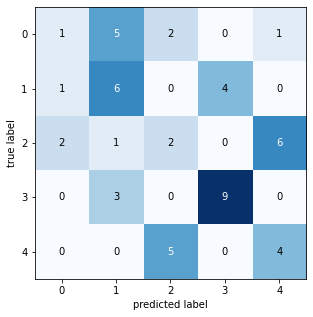

In [49]:
CM = confusion_matrix(y_test, predicted_labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [50]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [51]:
model_rand = RandomForestClassifier(n_estimators=1000, criterion = "entropy", max_depth = 5, random_state = 0)

In [52]:
model_rand.fit(preprocessor(X_train), y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=1000,
                       random_state=0)

In [53]:
print("Random Forest Classifier's cross validation accuracy:", np.mean(cross_val_score(model_rand, preprocessor(X_train), y_train, cv=10)))
print("Random Forest Classifier's Test-Data prediction accuracy: {:.5f}".format(model_rand.score(preprocessor(X_test), y_test)))

Random Forest Classifier's cross validation accuracy: 0.5536363636363636
Random Forest Classifier's Test-Data prediction accuracy: 0.50000


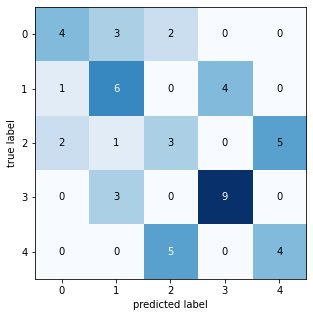

In [54]:
CM = confusion_matrix(y_test, model_rand.predict(preprocessor(X_test)))

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [55]:
from sklearn.svm import SVC

In [56]:
svc_pipe = Pipeline([('svc', SVC())])

svc_p = {
    'svc__C': [1, .5, 1e-1, 1e-2, 1e-3],
    'svc__gamma': ['scale', 'auto'],
}

svc = GridSearchCV(estimator = svc_pipe, param_grid = svc_p, cv = 3)

svc.fit(preprocessor(X_train), y_train)

GridSearchCV(cv=3, estimator=Pipeline(steps=[('svc', SVC())]),
             param_grid={'svc__C': [1, 0.5, 0.1, 0.01, 0.001],
                         'svc__gamma': ['scale', 'auto']})

In [57]:
print(svc.best_params_)

{'svc__C': 1, 'svc__gamma': 'scale'}


In [58]:
print("SVC's cross validation accuracy:", np.mean(cross_val_score(svc, preprocessor(X_train), y_train, cv=10)))
print("SVC's Test-Data prediction accuracy: {:.5f}".format(svc.score(preprocessor(X_test), y_test)))

SVC's cross validation accuracy: 0.5900000000000001
SVC's Test-Data prediction accuracy: 0.55769


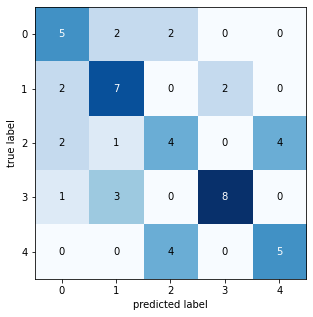

In [59]:
CM = confusion_matrix(y_test, svc.predict(preprocessor(X_test)))

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

Publicizing Work

In [60]:
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
Requirement already up-to-date: aimodelshare in /usr/local/lib/python3.6/dist-packages (0.0.22)


In [61]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

In [62]:
prep = ai.import_preprocessor("preprocessor.zip")

In [63]:
from aimodelshare.aimsonnx import model_to_onnx
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 32 -> 12


In [95]:
username = open("username.txt", "r")
password = open("password.txt", "r")

In [96]:
username = username.readline()
password = password.readline()

In [98]:
#aimodelshare username and password
import pickle

# load submit model creds (only gives access to s3 bucket)
# Load from pkl file
with open("aws_creds_worldhappiness.pkl", 'rb') as file:
    aws_key,aws_password,region = pickle.load(file)

token=ai.aws.get_aws_token(username, password)
awscreds=ai.aws.get_aws_client(aws_key=aws_key, aws_secret=aws_password, aws_region=region)

In [99]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token, awscreds, prediction_submission = predicted_labels,
                preprocessor="preprocessor.zip")

True

In [100]:
data=ai.get_leaderboard("https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=2)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data[data.username == 'eat2153']

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,loss,optimizer,model_config,username,timestamp,version
45,0.442308,0.436905,0.486111,0.456970,keras,NaN,True,Sequential,4.0,11373.0,4.0,str,SGD,"{'name': 'sequential_11', 'layers': [{'class_n...",eat2153,2021-02-02 00:17:57.730071,29
47,0.423077,0.426181,0.484225,0.437121,keras,NaN,True,Sequential,5.0,17549.0,5.0,str,SGD,"{'name': 'sequential_15', 'layers': [{'class_n...",eat2153,2021-02-02 00:27:22.924758,47
48,0.423077,0.426181,0.484225,0.437121,keras,NaN,True,Sequential,5.0,17549.0,5.0,str,SGD,"{'name': 'sequential_15', 'layers': [{'class_n...",eat2153,2021-02-02 00:32:09.285464,56
80,0.384615,0.384304,0.430101,0.397121,sklearn,NaN,NaN,RandomForestClassifier,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",eat2153,2021-02-02 00:23:24.502961,38
104,0.230769,0.240260,0.255238,0.239545,keras,NaN,True,Sequential,4.0,13389.0,4.0,str,SGD,"{'name': 'sequential_1', 'layers': [{'class_na...",eat2153,2021-02-08 22:34:33.512224,150
108,0.192308,0.186327,0.193173,0.199545,keras,NaN,True,Sequential,4.0,13389.0,4.0,str,SGD,"{'name': 'sequential_2', 'layers': [{'class_na...",eat2153,2021-02-08 22:43:52.435542,154
110,0.096154,0.090684,0.082455,0.106364,keras,NaN,True,Sequential,4.0,13389.0,4.0,str,SGD,"{'name': 'sequential_1', 'layers': [{'class_na...",eat2153,2021-02-08 23:38:27.278574,162
112,0.096154,0.090684,0.082455,0.106364,keras,NaN,True,Sequential,4.0,13389.0,4.0,str,SGD,"{'name': 'sequential_1', 'layers': [{'class_na...",eat2153,2021-02-08 23:08:28.882807,155
117,NaN,NaN,NaN,NaN,keras,NaN,True,Sequential,4.0,13389.0,4.0,str,SGD,"{'name': 'sequential_1', 'layers': [{'class_na...",eat2153,2021-02-08 22:39:32.000336,151
118,NaN,NaN,NaN,NaN,keras,NaN,True,Sequential,4.0,13389.0,4.0,str,SGD,"{'name': 'sequential_1', 'layers': [{'class_na...",eat2153,2021-02-08 22:40:01.004966,152
